# Generate a lens using _SLIT_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import scipy.signal as scp

import SLIT
import SLIT.Lens as Lens

from MuSLIT.utils.plot import nice_colorbar

%matplotlib inline

### Source setup

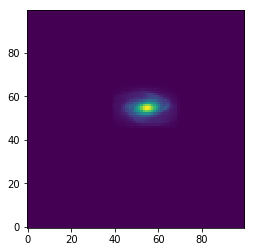

In [2]:
# Source light profile
source_path = "../Data/various_images/M81_HST_prepared_n100.fits"
source = pf.open(source_path)[0].data
source *= 10 # increase the flux, for comparison with lenstronomy sim

plt.imshow(source, origin='lower')
plt.show()

### PSF setup

(73, 73)


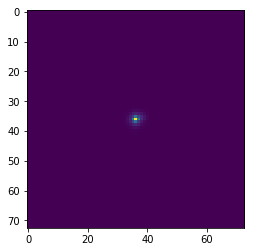

In [3]:
# N1,N2 are the numbers of pixels in the image plane.
num_pix = 100

# Size ratio of the source to image number of pixels 
size = 1

#PSF
PSF0 = pf.open('../Data/SLIT_images/PSF.fits')[0].data
PSF = PSF0[1:,1:]
PSFconj = np.real(np.fft.ifft2(np.conjugate(np.fft.fft2(PSF0[:-1,:-1]))))
PSFconj = PSFconj/np.sum(PSFconj)
PSF = PSF/np.sum(PSF)
print(PSF.shape)

plt.imshow(PSF)

In [4]:
# Compute the convergence kappa
k0 = 20
gamma = 2
q = 0.5
theta = -65  # degrees
rc = 0.00000001
extended_num_pix = 1000
x0_ext, y0_ext = extended_num_pix/2+0.5, extended_num_pix/2+0.5
kappa_extended = Lens.Power_law(x0_ext, y0_ext, extended_num_pix, extended_num_pix, k0, theta, q, gamma, rc)

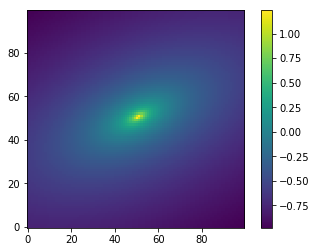

In [5]:
kappa = kappa_extended[int(x0_ext-num_pix/2):int(x0_ext+num_pix/2), int(y0_ext-num_pix/2):int(y0_ext+num_pix/2)]

plt.imshow(np.log10(kappa), origin='lower')
plt.colorbar()
plt.show()

In [6]:
# Mapping between lens and source IMPORTANT
Fkappa = SLIT.Lens.F(kappa_extended, num_pix, num_pix, size)

In [7]:
# Generation of lensed source
I2 = SLIT.Lens.source_to_image(source, num_pix, num_pix, Fkappa)

# Convolution by the PSF and generation of the final image
image_no_noise = scp.fftconvolve(I2, PSF, mode='same')

# Noise levels
SNR = 100
sigma = np.sqrt(np.sum(I2**2)/SNR/(num_pix**2 * size**2))
noise = np.random.randn(num_pix, num_pix)*sigma

# Final simulated image
image_sim = image_no_noise + noise

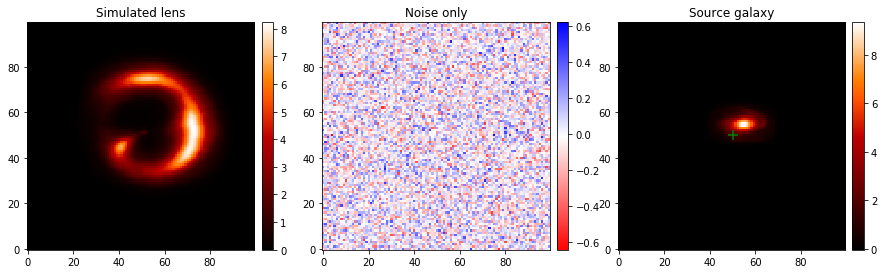

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes[0]
ax.set_title("Simulated lens")
im = ax.imshow(image_no_noise, origin='lower', cmap='gist_heat')
nice_colorbar(im)

ax = axes[1]
ax.set_title("Noise only")
im = ax.imshow(image_sim-image_no_noise, origin='lower', cmap='bwr_r') #, vmin=-0.1, vmax=0.1)
nice_colorbar(im)

ax = axes[2]
ax.set_title("Source galaxy")
im = ax.imshow((source), origin='lower', cmap='gist_heat')
ax.scatter(num_pix/2., num_pix/2., color='green', marker='+', s=120) # center of the image
nice_colorbar(im)

plt.show()